## FYS-STK4155 
## Project 1

This notebook uses scikit learn to for machine learning algorithms etc. 

### Configure Notebook


In [1]:
import os

import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

### Franke's function

Franke's bivariate test function, commonly just called Franke's function, is a widely used test function in interpolartion and fitting problems. As seen in the plot below, Franke's function has two Gaussian peaks and a Gaussian dip. 

In [2]:
def frankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9 * x - 2)**2) - 0.25 * ((9 * y - 2)**2))
    term2 = 0.75 * np.exp(-((9 * x + 1)**2) / 49.0 - 0.1 * (9 * y + 1))
    term3 = 0.5 * np.exp(-(9 * x - 7)**2 / 4.0 - 0.25 * ((9 * y - 3)**2))
    term4 = -0.2 * np.exp(-(9 * x - 4)**2 - (9 * y - 7)**2)
    return term1 + term2 + term3 + term4

def plotFranke(save=False):
    x = np.arange(0, 1, 0.05)
    y = np.arange(0, 1, 0.05)
    x, y = np.meshgrid(x, y) 
    z = frankeFunction(x, y)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection="3d")
    surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, lw=0, antialiased=False)
    ax.set_zlim(-0.10, 1.40)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_title("Franke's function", fontsize=16)
    ax.set_xlabel("x", fontsize=12)
    ax.set_ylabel("y", fontsize=12)
    ax.zaxis.set_rotate_label(False) # disable automatic rotation
    ax.set_zlabel("f(x,y)", fontsize=12, rotation=90)
    ax.view_init(elev=15, azim=45)
    plt.show()
    if save:
        fig.savefig("Franke_func.png")
    

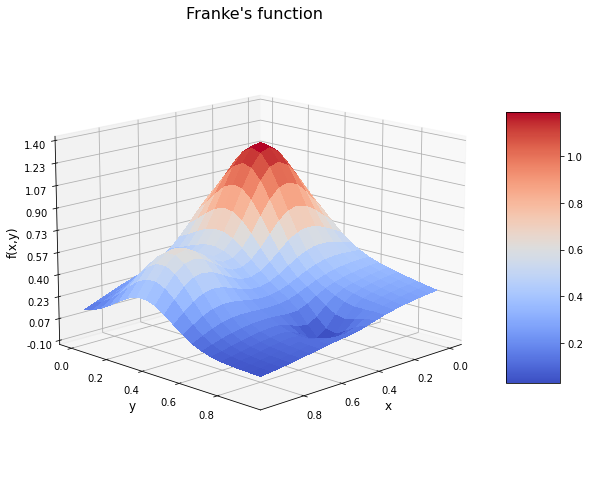

In [3]:
plotFranke()

### Creating the Design Matrix

We will fit a polynomial function to the data points of Franke's bivariate test function. We can use linear regression for this. First we create our design matrix (a pseudo-Vandermonde matrix):

In [4]:
def designMatrix(x, y, deg, with_intercept=True):
    """
    Create design matrix
    
    Set with_intercept to True if an intercept column should be included, False if not
    
    Note: (not with_intercept) evaluates to 0 if with_intercept is True and 1 if False
    """
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((deg + 1) * (deg + 2) / 2) - (not with_intercept) # Number of elements in beta
    X = np.ones((N, l))
    
    idx = 0
    for i in range((not with_intercept), deg + 1):
        for j in range(i + 1):
            X[:, idx] = x**(i - j) * y**j
            idx += 1

    return X



Sanity check:

In [5]:
x = np.array([2, 3])
y = np.array([4, 5])
deg = 2
X = designMatrix(x, y, deg, with_intercept=True)
print(X)

[[ 1.  2.  4.  4.  8. 16.]
 [ 1.  3.  5.  9. 15. 25.]]


### Create Data and Perform Ordinary Least Squares (OLS) Linear Regression

Here, we perform an ordinary least squares regression analysis using polynomials in $x$ and $y$ up to the fifth order. We split the data into training and test sets, and also scale the data. 

In [6]:
# Create data
np.random.seed(42)

n = 100          # number of data points
deg = 5          # degree
sigma2 = 0.001   # irreducible error

# x = np.random.uniform(0, 1, n)
# y = np.random.uniform(0, 1, n)

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma2, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# Generate design matrix
X = designMatrix(x, y, deg, with_intercept=False)
print(f"Design matrix shape: {X.shape}")

# Split data into train and test sets
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Scale the data, i.e, subtract the mean and divide by the std
# scaler.fit computes the mean and std to be used for later scaling
# It is important that this is done on the training set
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create linear regression object
ols_linreg = LinearRegression(fit_intercept=True)

# Train the model using the (scaled) training sets
ols_linreg.fit(X_train_scaled, z_train)
z_fit = ols_linreg.predict(X_train_scaled)

# Make predictions using the test set
z_pred = ols_linreg.predict(X_test_scaled)

# Intercept and coefficients
beta0 = ols_linreg.intercept_
beta = ols_linreg.coef_
print(f"Intercept: {beta0}")
print("Coefficients: \n", beta)
print(f"Coefficients shape: {beta.shape}")

# MSE
mse_train = mean_squared_error(z_train, z_fit)
mse_test = mean_squared_error(z_test, z_pred)
print(f"Train MSE: {mse_train}")
print(f"Test MSE: {mse_test}")

# R2
r2_train = r2_score(z_train, z_fit)
r2_test = r2_score(z_test, z_pred)
print(f"Train R2: {r2_train}")
print(f"Test R2: {r2_test}")

Design matrix shape: (10000, 20)
Intercept: 0.40701187713776826
Coefficients: 
 [  2.28213418   1.08144017 -10.33009742  -3.35102077  -2.47004449
  13.90335248   8.92917029   4.01004306  -2.55419538  -6.47716633
  -9.77236504  -1.29295833  -5.20255291   8.04151688   0.40831116
   3.23114729   1.57568605  -0.80163504   2.7014713   -4.2276273 ]
Coefficients shape: (20,)
Train MSE: 0.002074360835297836
Test MSE: 0.0021265271027237735
Train R2: 0.9749504649040797
Test R2: 0.9735919267433816


### MSE and R2 as a function of model complexity





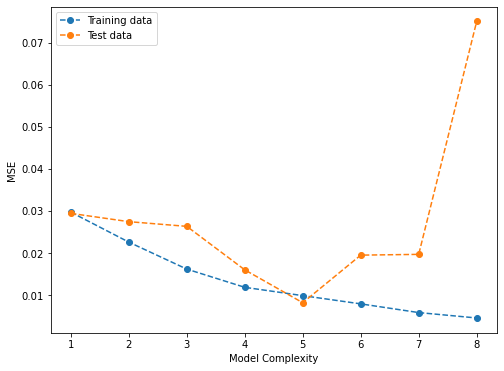

In [7]:
# Create data
np.random.seed(42)

n = 10         # number of data points
sigma2 = 0.1   # irreducible error

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma2, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

maxdeg = 8
degrees = np.arange(1, maxdeg+1, dtype=int)

mse = pd.DataFrame(columns=["train", "test"], index=degrees-1)
r2 = pd.DataFrame(columns=["train", "test"], index=degrees-1)

for i, deg in enumerate(degrees):

    # Generate design matrix
    X = designMatrix(x, y, deg, with_intercept=False)

    # Split data into train and test sets
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    # Scale the data, i.e, subtract the mean and divide by the std
    # scaler.fit computes the mean and std to be used for later scaling
    # It is important that scaling is done based on the training set
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create linear regression object
    ols_linreg = LinearRegression(fit_intercept=True)

    # Train the model using the (scaled) training sets
    ols_linreg.fit(X_train_scaled, z_train)
    z_fit = ols_linreg.predict(X_train_scaled)

    # Make predictions using the test set
    z_pred = ols_linreg.predict(X_test_scaled)

    # Statistical metrics
    mse["train"][i] = mean_squared_error(z_train, z_fit)
    mse["test"][i] = mean_squared_error(z_test, z_pred)
    r2["train"][i] = r2_score(z_train, z_fit)
    r2["test"][i] = r2_score(z_test, z_pred)

fig = plt.figure(figsize=(8,6))
plt.plot(degrees, mse["train"], "o--", label="Training data")
plt.plot(degrees, mse["test"], "o--", label="Test data")
plt.xlabel("Model Complexity")
plt.ylabel("MSE")
plt.legend()
plt.show()

## Confidence Interval

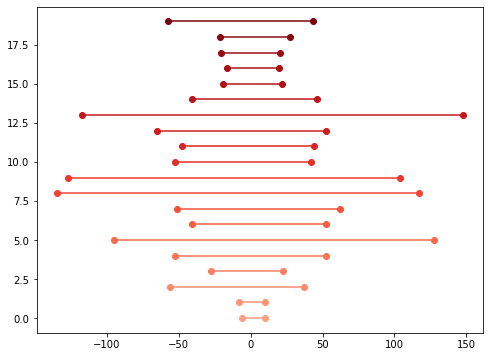

In [8]:
# Create data
np.random.seed(42)

n = 10         # number of data points
sigma2 = 0.1   # irreducible error
deg = 5

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma2, int(n*n))

# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# Generate design matrix
X = designMatrix(x, y, deg, with_intercept=False)

# Split data into train and test sets
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

# Scale the data, i.e, subtract the mean and divide by the std
# scaler.fit computes the mean and std to be used for later scaling
# It is important that scaling is done based on the training set
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create linear regression object
ols_linreg = LinearRegression(fit_intercept=True)

# Train the model using the (scaled) training sets
ols_linreg.fit(X_train_scaled, z_train)

# Get coefficients
beta = ols_linreg.coef_

# CI
z = 1.96  # 95% CI
beta_var = np.diag(np.linalg.pinv(X_train_scaled.T @ X_train_scaled))
beta_std = np.sqrt(beta_var)

CI = [[beta[i] - z * beta_std[i], beta[i] + z * beta_std[i]] for i in range(len(beta))]

# Make a nice plot
fig = plt.figure(figsize=(8, 6))

cmap = plt.get_cmap("Reds")
norm = matplotlib.colors.Normalize(vmin=-10, vmax=len(CI))

for i in range(len(CI)):
    plt.plot(CI[i], (i, i), color=cmap(norm(i)))
    plt.plot(CI[i], (i, i), "o", color=cmap(norm(i)))

    
plt.show()

**b)**

The bootstrap method is a resampling technique. Resampling involves repeatedly drawing samples from a training set and refitting a model of interest on each sample in order to obtain additional information about the fitted model. For example, in order to estimate the variability of a linear regression fit, we can repeatedly draw different samples from the training data, fit a linear regression to each new sample, and then examine the extent to which the resulting fits differ. Such an approach may allow us to obtain information that would not be available from fitting the model only once using the original training sample. 

Annen approach: tar 1 degree, en bias verdi, gjort det mange ganger med ulike train, test og split av data for å få mer representativt. Burde gjort en cross-validation over dette (ny ytre løkke). 

**viktig poeng**: burde hatt en ytre loop til utenfor, for experiment in range(n_experiments): for hver grad, mange ganger. Ny train, test, split for hvert eksperiment for hver grad, og tatt snittet av disse. Bare ett testsett, er et stokastisk forsøk. 

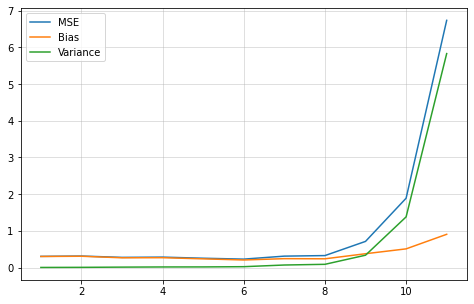

In [9]:
# Create data
np.random.seed(41)

n = 20         # number of data points
sigma2 = 0.5   # irreducible error

x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
noise = np.random.normal(0, sigma2, int(n*n))
                         
# Create mesh and unravel
x, y = np.meshgrid(x, y)
x = np.ravel(x)
y = np.ravel(y)

# Observed data
z = frankeFunction(x, y) + noise

# setup for bootstrap
maxdeg = 11
degrees = np.arange(1, maxdeg+1, dtype=int)
n_bootstraps = 500

bias2 = np.zeros(maxdeg)
variance = np.zeros(maxdeg)

for i, deg in enumerate(degrees):

    # Generate design matrix
    X = designMatrix(x, y, deg, with_intercept=False)

    # Split data into train and test sets
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2)

    # Scale the data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    z_pred = np.empty((z_test.shape[0], n_bootstraps))
    
    for trial_idx in range(n_bootstraps):
        X_, z_ = resample(X_train_scaled, z_train)
        ols_linreg = LinearRegression(fit_intercept=True)
        z_pred[:, trial_idx] = ols_linreg.fit(X_, z_).predict(X_test_scaled)
    
    bias2[i] = np.mean((z_test - np.mean(z_pred, axis=1))**2) # bias^2
    variance[i] = np.mean(np.var(z_pred, axis=1))
    
MSE = bias2 + variance
fig = plt.figure(figsize=(8, 5))
plt.grid(alpha=0.5)
plt.plot(degrees, MSE, label='MSE')
plt.plot(degrees, bias2, label='Bias')
plt.plot(degrees, variance, label='Variance')
plt.legend()
plt.show()